# 1D finite volume convection-diffusion

(inspired by Versteeg example 5.1)

The 1D convection-diffusion equation (without sources) is:

$$\frac{d}{dx}\left( \rho u \phi \right) = \frac{d}{dx}\left( \Gamma  \frac{d\phi}{dx}\right)$$

<img src="convectionDiffusion_notation.png">

Integrate using Gauss' law on both sides:

$$  \left[ \left( \rho u \phi \right)_e - \left( \rho u \phi \right)_w \right] A = \left[ \left(  \Gamma  \frac{d\phi}{dx} \right)_e - \left(  \Gamma  \frac{d\phi}{dx} \right)_w \right] A$$

Cell face area divides out. Use central difference for diffusion term:

$$ \underbrace{\rho_e u_e}_{F_e} \phi_e - \underbrace{\rho_w u_w}_{F_e} \phi_w = \underbrace{\frac{\Gamma_e}{\delta x_{PE}}}_{D_e} \left(  \phi_E - \phi_P \right) - \underbrace{\frac{\Gamma_w}{\delta x_{WP}}}_{D_w} \left(  \phi_P - \phi_W \right) $$

### Convection schemes

Observation: The convective term includes $\phi_e$ and $\phi_w$, which we need to obtain from our cell values. Even though this seems like a trivial task (just use central difference, right?), **it is not!!!** This term can lead to all sorts of numerical problems (overshoots, wiggles and divergent solutions). It is especially critical at large Peclet numbers (coarse grid or fast speed) equivalent to convection-dominated problems:

$$ \mathrm{Pe} = \frac{\rho u}{\Gamma/\delta x} \approx \frac{\mathrm{convection}}{\mathrm{diffusion}}$$

In this notebook, we will take a look at different convection schemes:

- Central difference
- Upwind
- QUICK
- Linear upwind
- TVD


### Problem:

We will assume the velocity, $u$, is known a-priori and solve the following problem for $\phi(x)$:

<img src="convDiff_problem.png">

- $u(x) = 0.1~\mathrm{m/s}$
- $\phi_A = 1$
- $\phi_B = 0$
- $N = 5$
- $L = 1~\mathrm{m} \Rightarrow \delta x = 0.2~\mathrm{m}$
- $\rho = 1.0~\mathrm{kg/m}^3$
- $\Gamma = 0.1~\mathrm{kg/(m s)}$


The analytical solution of the problem is:

$$ \frac{\phi - \phi_A}{\phi_B - \phi_A} = \frac{\mathrm{exp}(\rho u x / \Gamma) - 1}{\mathrm{exp}(\rho u L / \Gamma) - 1}$$

[0.1 0.3 0.5 0.7 0.9]


Text(0, 0.5, '$\\phi$')

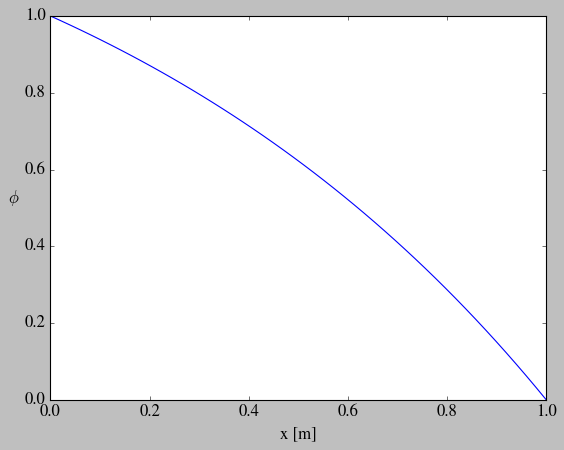

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from scipy.optimize import fsolve
import time
mpl.style.use('classic')
# Latex font
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 15
plt.rcParams["legend.scatterpoints"] = 1
plt.rcParams["legend.numpoints"] = 1
yd = dict(rotation=0,ha='right') # I couldn't find a way to customize these, so use a dict everytime..

## Constants
N = 5
L = 1.0; dx = L/N
x = np.linspace(dx/2,L-dx/2,N)
print(x)
Gamma = 0.1
phi_A = 1.0
phi_B = 0.0
rho = 1.0
u = 0.1
F = rho*u
D = Gamma/dx
D_A = 2*Gamma/dx
D_B = 2*Gamma/dx


## Analytical solution
x_an = np.linspace(0,L,50)
phi_an = (phi_B - phi_A)*(np.exp(rho*u*x_an/Gamma) - 1)/(np.exp(rho*u*L/Gamma) - 1) + phi_A

fig = plt.figure()
plt.plot(x_an, phi_an)
plt.xlabel('x [m]')
plt.ylabel('$\phi$',yd)


### Central difference convection scheme

Simply use:

$$ \phi_e = \frac{\phi_E + \phi_P}{2} \quad , \quad \phi_w = \frac{\phi_P + \phi_W}{2}$$


$$ F_e \left(\frac{\phi_E + \phi_P}{2}\right) - F_w \left(\frac{\phi_P + \phi_W}{2}\right) = D_e \left(  \phi_E - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left(\frac{F_e }{2} -  \frac{F_w}{2} + D_e + D_w\right) \phi_P =   \left(D_e  -\frac{F_e  }{2}\right) \phi_E +  \left(D_w  + \frac{F_w  }{2}  \right) \phi_W $$

Here $F_e = F_w = \rho u$ at all nodes and boundary faces. $D_w = D_e = \frac{\Gamma}{\delta x}$ is only true at interal nodes and $D_A = D_B = \frac{\Gamma}{\delta x / 2}$. Special care is needed for the boundary cells.

Node 1:

$$ F_e \left(\frac{\phi_E + \phi_P}{2}\right) - F_w \phi_A = D_e \left(  \phi_E - \phi_P \right) - D_A \left(  \phi_P - \phi_A \right) $$

$$ \Rightarrow  \left(\frac{F_e }{2}  + D_e + D_A\right) \phi_P =   \left(D_e  -\frac{F_e  }{2}\right) \phi_E + \left(D_A + F_w\right) \phi_A$$


Node 5:

$$  F_e \phi_B - F_w \left(\frac{\phi_P + \phi_W}{2}\right) = D_B \left(  \phi_B - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left(-  \frac{F_w}{2} + D_B + D_w\right) \phi_P =     \left(D_w  + \frac{F_w  }{2}  \right) \phi_W + \left(D_B  -F_e \right) \phi_B$$

A matrix:
[[ 1.55 -0.45  0.    0.    0.  ]
 [-0.55  1.   -0.45  0.    0.  ]
 [ 0.   -0.55  1.   -0.45  0.  ]
 [ 0.    0.   -0.55  1.   -0.45]
 [ 0.    0.    0.   -0.55  1.45]]

b vector:
[1.1 0.  0.  0.  0. ]
[0.94210996 0.80060097 0.62764554 0.41625556 0.15789004]


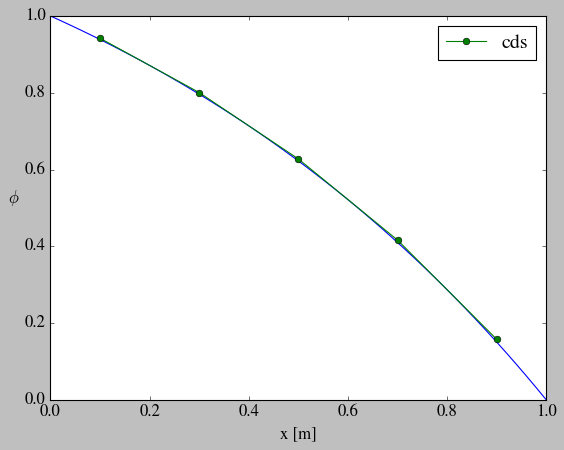

In [2]:
## Tri-diagonal matrix shortcut
def tridiag(a1, a2, a3, k1=-1, k2=0, k3=1):
    '''
    Create N x N tri-diagonal matrix
    a1 is the lower-diagonal (size N-1)
    a2 is the diagonal       (size N)
    a3 is the upper-diagonal (size N-1)
    Don't touch the k's!
    '''
    return np.diag(a1, k1) + np.diag(a2, k2) + np.diag(a3, k3)


def create_tridiag_matrix(a1,a2,a3,N,a2_1,a2_N):
    '''
    Create a tridiag type of matrix
    a1 = value at lower diagonal (scalar)
    a2 = value at diagonal (scalar)
    a3 = value at upper diagonal (scalar)
    N = size of matrix (scalar)
    a2_1 = element 1,1 (scalar)
    a2_N = element N,N (scalar)
    '''
    a1vec = np.ones(N-1)*a1   
    a2vec = np.ones(N)*a2
    a2vec[0] = a2_1; a2vec[-1] = a2_N
    a3vec = np.ones(N-1)*a3  
    return tridiag(a1vec, a2vec, a3vec)


## Assemble matrix
A = create_tridiag_matrix(-(D + F/2), 2*D, -(D - F/2), N, (F/2 + D + D_A), (-F/2 + D + D_B) )


## Assemble b-vector
b = np.zeros(N)
b[0] = (D_A + F)*phi_A; b[-1] = (D_B - F)*phi_B


## Print to screen
print('A matrix:')
print(A)

print('\nb vector:')
print(b)

phi_cd = np.matmul(np.linalg.inv(A),b)

print(phi_cd)

fig = plt.figure()
plt.plot(x_an, phi_an)
plt.plot(x, phi_cd, 'o-',label='cds')
plt.xlabel('x [m]')
plt.ylabel('$\phi$',yd)
plt.legend()

The solution is spot on! However, try to change $u = 0.1~\mathrm{m/s} \rightarrow 2.5~\mathrm{m/s}$... things blow up!

### Upwind convection scheme

Idea: Depending on face velocity, use the upstream value.

$$ \phi_e = \begin{cases} \phi_P \quad \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \phi_E \quad \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$


$$ \phi_w = \begin{cases} \phi_W \quad \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \phi_P \quad\, \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$

Note, there is no "mixed" case, because of continuity.

In general applications, one would evaluate these if expressions in each iteration, but for our problem we always have $u(x) > 0$. The 1D convection-diffusion equation then becomes (can easily be seen by looking at the central differencing derivation made above):

$$ \left( F_e  + D_e + D_w\right) \phi_P =   D_e   \phi_E +  \left(D_w  + F_w    \right) \phi_W $$

We have to care about boundary nodes again. Node 1:

$$ \left( F_e  + D_e + D_A\right) \phi_P =   D_e   \phi_E +  \left(D_A  + F_w    \right) \phi_A $$

Node 5:

$$ \left( F_e  + D_B + D_w\right) \phi_P =   D_B   \phi_B +  \left(D_w  + F_w    \right) \phi_W $$



A matrix:
[[ 1.6 -0.5  0.   0.   0. ]
 [-0.6  1.1 -0.5  0.   0. ]
 [ 0.  -0.6  1.1 -0.5  0. ]
 [ 0.   0.  -0.6  1.1 -0.5]
 [ 0.   0.   0.  -0.6  1.6]]

b vector:
[1.1 0.  0.  0.  0. ]
[0.93373341 0.7879469  0.6130031  0.40307053 0.15115145]


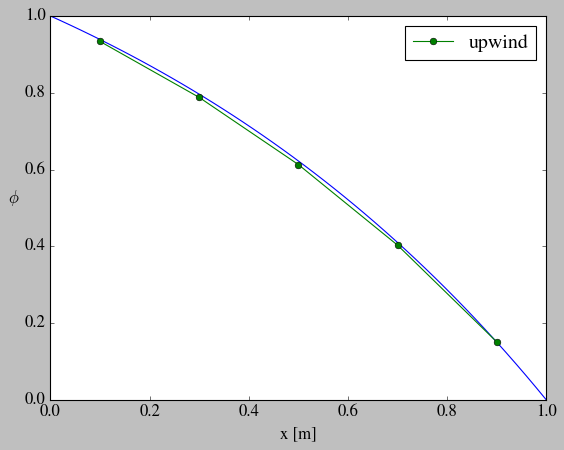

In [3]:
## Assemble matrix
A_up = create_tridiag_matrix(-(D + F), (F + 2*D), -(D), N, (F + D + D_A), (F + D_B + D) )


## Assemble b-vector
b_up = np.zeros(N)
b_up[0] = (D_A + F)*phi_A; b_up[-1] = D_B*phi_B


## Print to screen
print('A matrix:')
print(A_up)

print('\nb vector:')
print(b_up)

phi_up = np.matmul(np.linalg.inv(A_up),b_up)

print(phi_up)

fig = plt.figure()
plt.plot(x_an, phi_an)
plt.plot(x, phi_up, 'o-',label='upwind')
plt.xlabel('x [m]')
plt.ylabel('$\phi$',yd)
plt.legend()

Also pretty decent result. No problems, when changing to $u = 2.5~\mathrm{m/s}$!

The upwind scheme is only 1st order, while the CDS is 2nd order. This explains why the result of the upwind results are slightly off.

## QUICK convection scheme

The Quadratic Upstream Interpolation Convective Kinetics (QUICK) scheme is 2nd order accurate, but also uses upstream information like the upwind scheme, which makes it more physical and stable compared to the CDS.


$$ \phi_e = \begin{cases} \frac{6}{8}\phi_P + \frac{3}{8}\phi_E - \frac{1}{8}\phi_{W}  \quad\, \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \frac{6}{8}\phi_E + \frac{3}{8}\phi_P - \frac{1}{8}\phi_{EE} \quad \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$


$$ \phi_w = \begin{cases} \frac{6}{8}\phi_W + \frac{3}{8}\phi_P - \frac{1}{8}\phi_{WW} \,\, \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \frac{6}{8}\phi_P + \frac{3}{8}\phi_W - \frac{1}{8}\phi_{E} \quad\, \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$

Again, no mixed cases, because of continuity. The logic behind these coefficients can be seen on p.157 of Versteeg.


Also again, we simply use the $u > 0$ cases in our test problem, which yields:

$$ F_e \left(\frac{6}{8}\phi_P + \frac{3}{8}\phi_E - \frac{1}{8}\phi_{W}\right) - F_w \left(\frac{6}{8}\phi_W + \frac{3}{8}\phi_P - \frac{1}{8}\phi_{WW}\right) = D_e \left(  \phi_E - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left(\frac{6F_e }{8} -  \frac{3F_w}{8} + D_e + D_w\right) \phi_P =   \left(D_e  -\frac{3F_e  }{8}\right) \phi_E +  \left(D_w  + \frac{6F_w  }{8} + \frac{F_e  }{8}  \right) \phi_W - \frac{F_w  }{8}  \phi_{WW} $$

As always, special care is needed for the boundary cells, but now also for the cell *adjacent* to boundary cell, because of $\phi_{WW}$! We use a "mirror cell" (aka "ghost cell"?) to take care of that.

<img src="mirror_cell.png">

This will give $\phi_0 = 2 \phi_A - \phi_P$, which can be used as a "W". Also, the diffusive flux at the east face of node 1 and west face of cell 5 need to be modified to be consistent (p.160 of Versteeg, **this I should explain better in the future**).

Node 1:

$$ F_e \left(\frac{6}{8}\phi_P + \frac{3}{8}\phi_E - \frac{1}{8}\left[2 \phi_A - \phi_P \right]\right) - F_w \phi_A = D_e \left(  \phi_E - \phi_P \right) - \frac{D_A}{6} \left( 9 \phi_P - 8\phi_A - \phi_E \right) $$

$$ \Rightarrow  \left(\frac{7F_e }{8}  + D_e + \frac{3}{2} D_A \right) \phi_P =   \left(D_e  -\frac{3F_e  }{8} + \frac{D_A}{6}\right) \phi_E +  \left(\frac{4}{3} D_A + \frac{F_e}{4} + F_w \right) \phi_A  $$

Node 2:

$$ F_e \left(\frac{6}{8}\phi_P + \frac{3}{8}\phi_E - \frac{1}{8}\phi_{W}\right) - F_w \left(\frac{7}{8}\phi_W + \frac{3}{8}\phi_P - \frac{2}{8}\phi_{A}\right) = D_e \left(  \phi_E - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left(\frac{6F_e }{8} -  \frac{3F_w}{8} + D_e + D_w\right) \phi_P =   \left(D_e  -\frac{3F_e  }{8}\right) \phi_E +  \left(D_w  + \frac{7F_w  }{8} + \frac{F_e  }{8}  \right) \phi_W - \frac{F_w  }{4}  \phi_{A} $$

Node 5:

$$ F_e \phi_B - F_w \left(\frac{6}{8}\phi_W + \frac{3}{8}\phi_P - \frac{1}{8}\phi_{WW}\right) = \frac{D_B}{6} \left(  8\phi_B - 9\phi_P + \phi_W \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left(-  \frac{3F_w}{8} + \frac{3}{2} D_B + D_w\right) \phi_P =   \frac{4 D_B  }{3} \phi_B +  \left(D_w  + \frac{6F_w  }{8} + \frac{D_B  }{6}  \right) \phi_W - \frac{F_w  }{8}  \phi_{WW} $$



A matrix:
[[ 2.0875     -0.62916667  0.          0.          0.        ]
 [-0.6         1.0375     -0.4625      0.          0.        ]
 [ 0.0125     -0.5875      1.0375     -0.4625      0.        ]
 [ 0.          0.0125     -0.5875      1.0375     -0.4625    ]
 [ 0.          0.          0.0125     -0.74166667  1.9625    ]]

b vector:
[ 1.45833333 -0.025       0.          0.          0.        ]
[0.93854574 0.79610208 0.62233181 0.41014294 0.15103704]


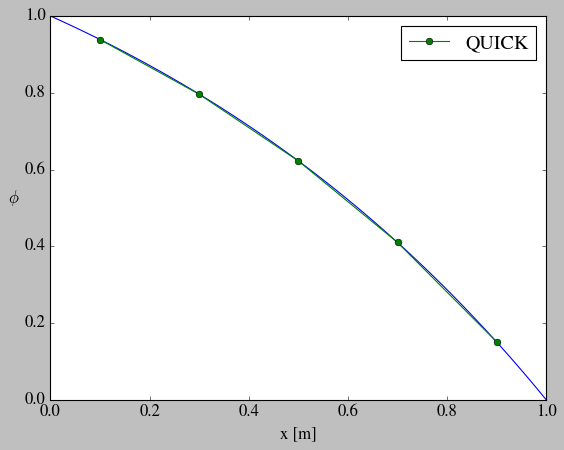

In [4]:
## Penta-diagonal matrix shortcut
def pentadiag(a0, a1, a2, a3, a4, k0=-2, k1=-1, k2=0, k3=1, k4=2):
    '''
    Create N x N penta-diagonal matrix
    a0 is the lower-lower-diagonal (size N-2)
    a1 is the lower-diagonal (size N-1)
    a2 is the diagonal       (size N)
    a3 is the upper-diagonal (size N-1)
    a3 is the upper-upper-diagonal (size N-2)
    Don't touch the k's!
    '''
    return np.diag(a0, k0) + np.diag(a1, k1) + np.diag(a2, k2) + np.diag(a3, k3) + + np.diag(a4, k4)


def create_pentadiag_matrix(a0,a1,a2,a3,a4,N,a2_1,a2_N):
    '''
    Create a pentadiag type of matrix
    a0 = value at lower-lower diagonal (scalar)
    a1 = value at lower diagonal (scalar)
    a2 = value at diagonal (scalar)
    a3 = value at upper diagonal (scalar)
    a4 = value at upper-upper diagonal (scalar)
    N = size of matrix (scalar)
    a2_1 = element 1,1 (scalar)
    a2_N = element N,N (scalar)
    '''
    a0vec = np.ones(N-2)*a0   
    a1vec = np.ones(N-1)*a1   
    a2vec = np.ones(N)*a2
    a2vec[0] = a2_1; a2vec[-1] = a2_N
    a3vec = np.ones(N-1)*a3  
    a4vec = np.ones(N-2)*a4  
    return pentadiag(a0vec, a1vec, a2vec, a3vec, a4vec)


## Assemble matrix
A_q = create_pentadiag_matrix(-(-F/8), -(D + 7/8*F), (3/8*F + 2*D), -(D - 3/8*F), -(0), N, (7/8*F + D + 3/2*D_A), (-3/8*F + 3/2*D_B + D) )
A_q[0,1] = -(D - 3/8*F + D_A/6)   # Cell 1, phi_E modification
A_q[1,0] = -(D + F)   # Cell 2, phi_W modification
A_q[-1,-2] = -(D + 6/8*F + D_B/6)   # Cell 5, phi_W modification

## Assemble b-vector
b_q = np.zeros(N)
b_q[0] = (4/3*D_A + F/4 + F)*phi_A
b_q[1] = - F/4*phi_A
b_q[-1] = 4/3*D_B*phi_B


## Print to screen
print('A matrix:')
print(A_q)

print('\nb vector:')
print(b_q)


phi_q = np.matmul(np.linalg.inv(A_q),b_q)

print(phi_q)

fig = plt.figure()
plt.plot(x_an, phi_an)
plt.plot(x, phi_q, 'o-',label='QUICK')
plt.xlabel('x [m]')
plt.ylabel('$\phi$',yd)
plt.legend()

Beautiful fit! Does however give wiggles for $u = 2.5~\mathrm{m/s}$ (like CDS)... Versteeg says that this can indeed happen for QUICK and suggests the **defered correction** extension of Hayase (1992) to improve the stability.

### Linear upwind convection scheme

Is a 2nd order extension of the regular upwind scheme:


$$ \phi_e = \begin{cases} \phi_P + \frac{(\phi_P - \phi_W)}{\delta x} \frac{\delta x}{2}  \quad\, \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \phi_E - \frac{(\phi_{EE} - \phi_E)}{\delta x} \frac{\delta x}{2} \quad \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$


$$ \phi_w = \begin{cases} \phi_W + \frac{(\phi_W - \phi_{WW})}{\delta x} \frac{\delta x}{2} \,\, \mathrm{if}~u_w > 0~\mathrm{and}~u_e > 0 \\ \phi_P - \frac{(\phi_E - \phi_P)}{\delta x} \frac{\delta x}{2} \quad\,\,\, \mathrm{if}~u_w < 0~\mathrm{and}~u_e < 0 \end{cases}$$

This will also lead to a penta-diagonal system, which we will not bother to discretize here. 


Let's appreciate its similarity with the previous schemes ($u>0$ case):

$$ \phi_e = \phi_P + \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right)$$
$$ \phi_w = \phi_W + \frac{\psi(r_w)}{2} \left(\phi_P - \phi_W \right)$$

- CDS: $\psi(r) = 1$
- Upwind: $\psi(r) = 0$
- QUICK: $\psi(r) = \frac{3 + r}{4}$
- Linear upwind: $\psi(r) = r$

, where $r_e \equiv \frac{\phi_P - \phi_W}{\phi_E - \phi_P}$ and $r_w \equiv \frac{\phi_W - \phi_{WW}}{\phi_P - \phi_W}$.



### Total Variation Diminishing (TVD) convection scheme

Various theorems can be derived about $\psi(r)$ and its relation to stability. These are based on the principle of TVD, but the bottom line is that $\psi(r)$ should be limited to the "blue" area to get a stable, 2nd order scheme:


<img src="TVD_regions.png">

A scheme limited to this area is called "flux limited" and many $\psi(r)$ satisfying this exist.

Let's apply a flux limited convection scheme to our $u>0$ example from earlier:

$$ F_e  \left(\phi_P + \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right) - F_w \left(\phi_W + \frac{\psi(r_w)}{2} \left(\phi_P - \phi_W \right) \right) = D_e \left(  \phi_E - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left( F_e  + D_e + D_w\right) \phi_P =   D_e  \phi_E +  \left(D_w  + F_w    \right) \phi_W + \underbrace{\left[- F_e \left( \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right) + F_w  \left( \frac{\psi(r_w)}{2} \left(\phi_P - \phi_W \right) \right)  \right]}_{S_u^{DC}} $$

Here $S_u^{DC}$ is evaluated using the previous iteration (called "deferred correction", see p.172) and thus only *iterative* matrix solvers can be used!

Special care is needed for the boundary cells. Node 1:


$$ F_e  \left(\phi_P + \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right) - F_w \phi_A = D_e \left(  \phi_E - \phi_P \right) - \frac{D_A}{2} \left(  \phi_P - \phi_A \right) $$

$$ \Rightarrow  \left( F_e  + D_e + \frac{D_A}{2}\right) \phi_P =   D_e  \phi_E +  \left( \frac{D_A}{2} + F_w \right)  \phi_A + \underbrace{\left[- F_e \left( \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right)   \right]}_{S_u^{DC}} $$

, where $r_e = r_e^*$ is computed with mirror cell approach:

$$ r_e^* = \frac{2 (\phi_P - \phi_A)}{\phi_E - \phi_P} \quad \mathrm{evaluated~at~cell~1} $$.

Node 2 (need to match west convective flux of cell 2 with east convective flux of cell 1 to have conservative scheme):

$$ F_e  \left(\phi_P + \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right) - F_w \left(\phi_W + \frac{\psi(r_e^*)}{2} \left(\phi_P - \phi_W \right) \right)  = D_e \left(  \phi_E - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left( F_e  + D_e + D_w\right) \phi_P =   D_e  \phi_E +  \left(D_w  + F_w    \right) \phi_W + \underbrace{\left[- F_e \left( \frac{\psi(r_e)}{2} \left(\phi_E - \phi_P \right) \right) + F_w  \left( \frac{\psi(r_e^*)}{2} \left(\phi_P - \phi_W \right) \right)  \right]}_{S_u^{DC}} $$

Node 5:

$$ F_e  \phi_B - F_w \left(\phi_W + \frac{\psi(r_w)}{2} \left(\phi_P - \phi_W \right) \right) = \frac{D_B}{2} \left(  \phi_B - \phi_P \right) - D_w \left(  \phi_P - \phi_W \right) $$

$$ \Rightarrow  \left( \frac{D_B}{2} + D_w\right) \phi_P =   \left(F_e + \frac{D_B}{2}\right)  \phi_B +  \left(D_w  + F_w    \right) \phi_W + \underbrace{\left[F_w  \left( \frac{\psi(r_w)}{2} \left(\phi_P - \phi_W \right) \right)  \right]}_{S_u^{DC}} $$

We are now ready to assemble the tri-diagonal A matrix. The b vector will change upon each iteration due to the deferred correction method! Also, the b-vector depends on $\psi(r)$ (could first test with $\psi = 1$ corresponding to CDS and then afterwards with more complicated formulas).

In [ ]:
# Pseudo-code
def TVD(A, phi0, Nit=10):
    # Just invert A one time (A does not depend on iteration)
    Ainv = np.linalg.inv(A)
    
    # Assemble b from initial guess of phi
    b = (function of phi0)
    
    for i in range(Nit):
        # Solve A phi = b
        phi = np.matmul(Ainv, b)
        # Calculate new b giving this updated phi
        b =
        
    
    return phi


# Note: Maybe it is more common to implement deferred correction together with an iterative solver, since the inv(A)
# and many np.matmul's might be expensive?
    
    